# Deep Learning - MLP

In [1]:
# Imports
import os, sys, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
from typing import Tuple, Dict, Any

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.metrics import confusion_matrix

import joblib

# Shared utils
sys.path.append("../src")
from common_utils import (
    print_section, load_csv,
    stratified_train_val_test_split,
    build_preprocessor, split_X_y, fit_transform_dense,
    classification_metrics_from_proba, ensure_dir, save_json
)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)


In [2]:
@dataclass
class CFG:
    data_path: str = "../data/processed/rt_iot2022_dos_syn_model_ready.csv"
    label_col: str = "is_dos_syn_hping"
    categorical_cols: Tuple[str, ...] = ("proto", "service")

    test_size: float = 0.15
    val_size: float = 0.15
    seed: int = RANDOM_SEED

    hidden_units: Tuple[int, ...] = (128, 64, 32)
    dropout: float = 0.25
    lr: float = 1e-3
    batch_size: int = 512
    epochs: int = 50

    out_dir: str = "../artifacts_classifier"
    model_name: str = "dos_syn_mlp"

cfg = CFG()


In [3]:
# Load data
df_all = load_csv(cfg.data_path)
print_section("Loaded Dataset")
print("Shape:", df_all.shape)
print(df_all[cfg.label_col].value_counts())



Loaded Dataset
Shape: (123117, 85)
is_dos_syn_hping
1    94659
0    28458
Name: count, dtype: int64


In [4]:
# Stratified split (stable evaluation)
df_train, df_val, df_test = stratified_train_val_test_split(
    df_all, label_col=cfg.label_col, test_size=cfg.test_size, val_size=cfg.val_size, seed=cfg.seed
)

print_section("Split Sizes")
for name, df in [("Train", df_train), ("Val", df_val), ("Test", df_test)]:
    print(f"{name}: {df.shape}  Pos%: {df[cfg.label_col].mean()*100:.3f}")



Split Sizes
Train: (86181, 85)  Pos%: 76.886
Val: (18468, 85)  Pos%: 76.884
Test: (18468, 85)  Pos%: 76.884


In [5]:
# Preprocess: standardize numeric + one-hot encode proto/service
preprocessor, num_cols, cat_cols = build_preprocessor(df_train, label_col=cfg.label_col, categorical_cols=cfg.categorical_cols)
print_section("Preprocessing Columns")
print("Numeric:", len(num_cols))
print("Categorical:", cat_cols)

Xtr_df, ytr = split_X_y(df_train, cfg.label_col)
Xva_df, yva = split_X_y(df_val, cfg.label_col)
Xte_df, yte = split_X_y(df_test, cfg.label_col)

Xtr, Xva, Xte = fit_transform_dense(preprocessor, Xtr_df, Xva_df, Xte_df)

print_section("Transformed Shapes")
print("Xtr:", Xtr.shape, "ytr:", ytr.shape)
print("Xva:", Xva.shape, "yva:", yva.shape)
print("Xte:", Xte.shape, "yte:", yte.shape)



Preprocessing Columns
Numeric: 82
Categorical: ['proto', 'service']

Transformed Shapes
Xtr: (86181, 95) ytr: (86181,)
Xva: (18468, 95) yva: (18468,)
Xte: (18468, 95) yte: (18468,)


In [6]:
def compute_class_weights(y: np.ndarray) -> Dict[int, float]:
    classes, counts = np.unique(y, return_counts=True)
    total = counts.sum()
    return {int(c): float(total / (len(classes) * n)) for c, n in zip(classes, counts)}

def build_mlp(input_dim: int, hidden_units=(128,64,32), dropout=0.25, lr=1e-3) -> keras.Model:
    inputs = keras.Input(shape=(input_dim,))
    x = inputs
    for units in hidden_units:
        x = layers.Dense(units, activation="relu")(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(dropout)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            keras.metrics.BinaryAccuracy(name="accuracy"),
            keras.metrics.Precision(name="precision"),
            keras.metrics.Recall(name="recall"),
            keras.metrics.AUC(name="auc"),
        ],
    )
    return model



Model Summary


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 95)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        12,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,553 (92.00 KB)

 Trainable params: 23,105 (90.25 KB)

 Non-trainable params: 448 (1.75 KB)


Class Weights
{0: 2.1631777108433736, 1: 0.650314664734912}
Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9868 - auc: 0.9972 - loss: 0.0874 - precision: 0.9976 - recall: 0.9851 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0134 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0054 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0028 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0020 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 0.0013 - val_precision: 1.0000 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 1.0000 - auc: 1.0000 - loss: 0.0010 - precision: 1.0000 - recall: 1.0000 - va

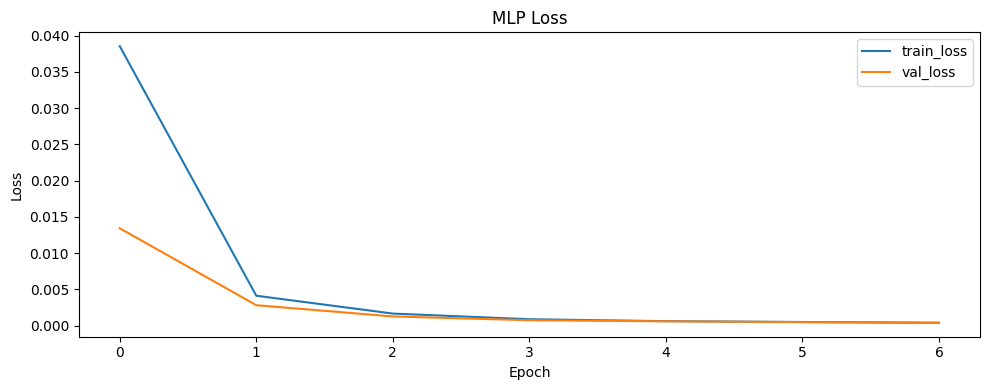

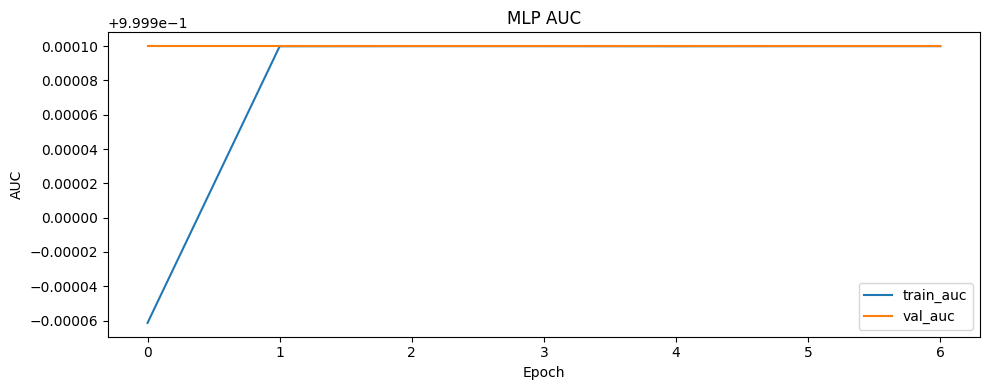

In [7]:
# Train
clf = build_mlp(Xtr.shape[1], cfg.hidden_units, cfg.dropout, cfg.lr)
print_section("Model Summary")
clf.summary()

class_weights = compute_class_weights(ytr)
print_section("Class Weights")
print(class_weights)

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=6, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(monitor="val_auc", mode="max", factor=0.5, patience=3, min_lr=1e-6),
]

history = clf.fit(
    Xtr, ytr,
    validation_data=(Xva, yva),
    epochs=cfg.epochs,
    batch_size=cfg.batch_size,
    class_weight=class_weights,
    callbacks=callbacks,
    verbose=1
)

# Learning curves
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("MLP Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(history.history["auc"], label="train_auc")
plt.plot(history.history["val_auc"], label="val_auc")
plt.title("MLP AUC")
plt.xlabel("Epoch")
plt.ylabel("AUC")
plt.legend()
plt.tight_layout()
plt.show()



Train Metrics @ threshold=0.5
      accuracy: 1.000000
     precision: 1.000000
        recall: 1.000000
            f1: 1.000000
       roc_auc: 1.000000
 avg_precision: 1.000000


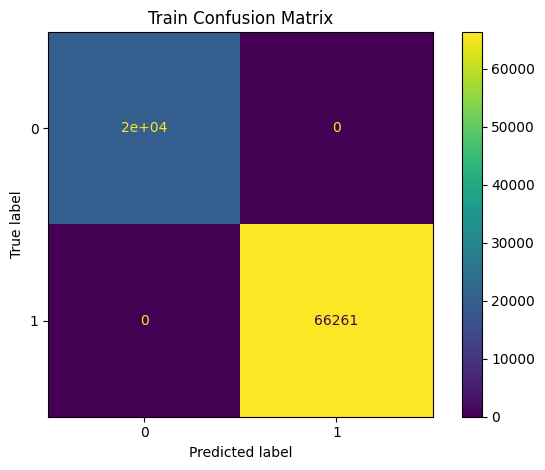

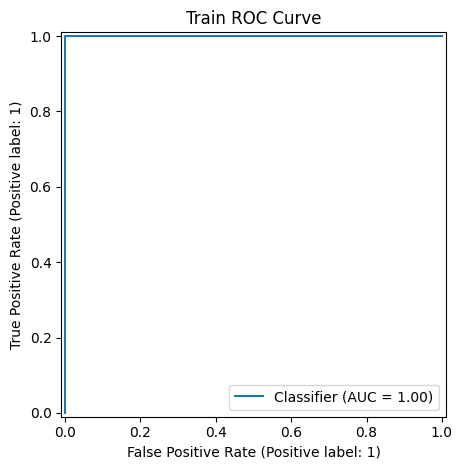

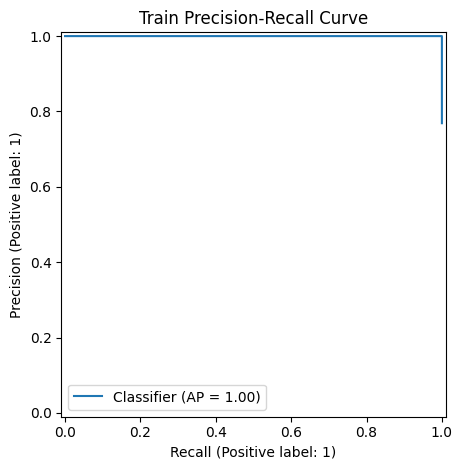


Validation Metrics @ threshold=0.5
      accuracy: 1.000000
     precision: 1.000000
        recall: 1.000000
            f1: 1.000000
       roc_auc: 1.000000
 avg_precision: 1.000000


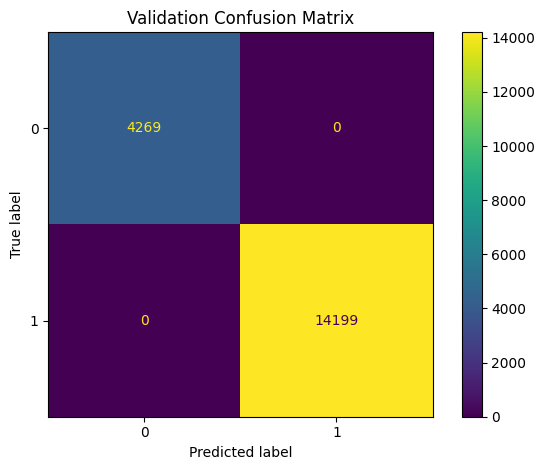

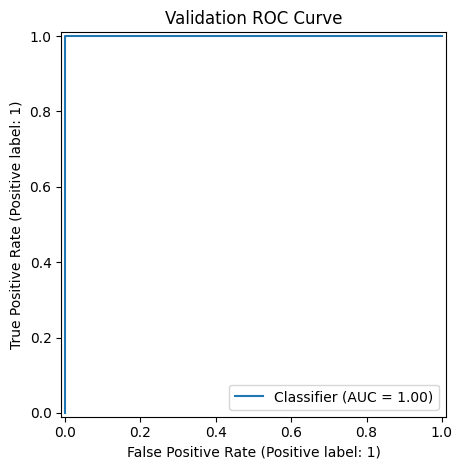

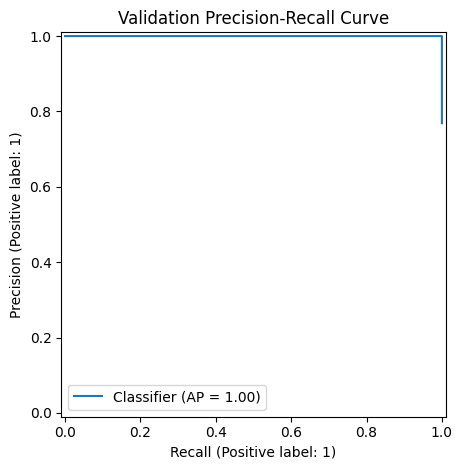


Test Metrics @ threshold=0.5
      accuracy: 1.000000
     precision: 1.000000
        recall: 1.000000
            f1: 1.000000
       roc_auc: 1.000000
 avg_precision: 1.000000


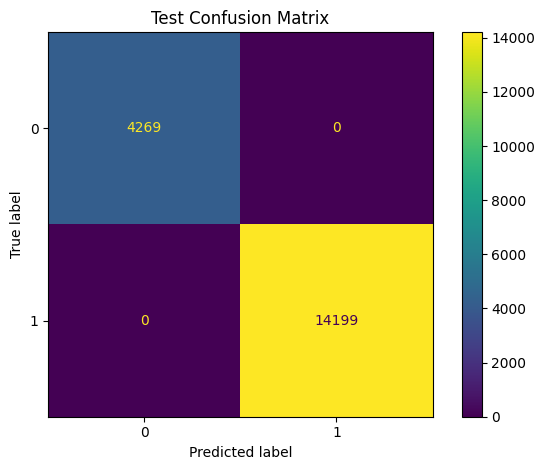

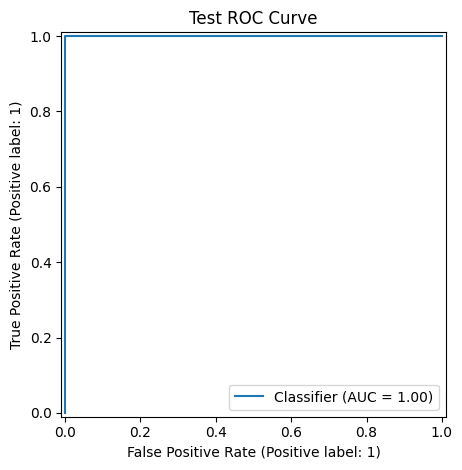

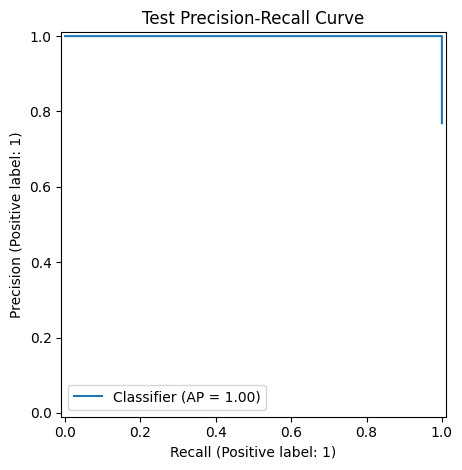

In [8]:
def evaluate_split(name: str, X: np.ndarray, y: np.ndarray, threshold: float = 0.5) -> Tuple[Dict[str, Any], np.ndarray]:
    proba = clf.predict(X, verbose=0).ravel()
    metrics = classification_metrics_from_proba(y, proba, threshold=threshold)

    print_section(f"{name} Metrics @ threshold={threshold}")
    for k in ["accuracy","precision","recall","f1","roc_auc","avg_precision"]:
        print(f"{k:>14}: {metrics[k]:.6f}")

    cm = confusion_matrix(y, (proba >= threshold).astype(int))
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f"{name} Confusion Matrix")
    plt.tight_layout()
    plt.show()

    RocCurveDisplay.from_predictions(y, proba)
    plt.title(f"{name} ROC Curve")
    plt.tight_layout()
    plt.show()

    PrecisionRecallDisplay.from_predictions(y, proba)
    plt.title(f"{name} Precision-Recall Curve")
    plt.tight_layout()
    plt.show()

    return metrics, proba

train_metrics, _ = evaluate_split("Train", Xtr, ytr, threshold=0.5)
val_metrics, _ = evaluate_split("Validation", Xva, yva, threshold=0.5)
test_metrics, test_proba = evaluate_split("Test", Xte, yte, threshold=0.5)



Threshold Sweep (Test)


,threshold,precision,recall,f1
0,0.05,0.999437,1.0,0.999718
1,0.10,0.999789,1.0,0.999894
2,0.15,0.999930,1.0,0.999965
3,0.20,1.000000,1.0,1.000000
4,0.25,1.000000,1.0,1.000000
5,0.30,1.000000,1.0,1.000000
6,0.35,1.000000,1.0,1.000000
7,0.40,1.000000,1.0,1.000000
8,0.45,1.000000,1.0,1.000000
9,0.50,1.000000,1.0,1.000000


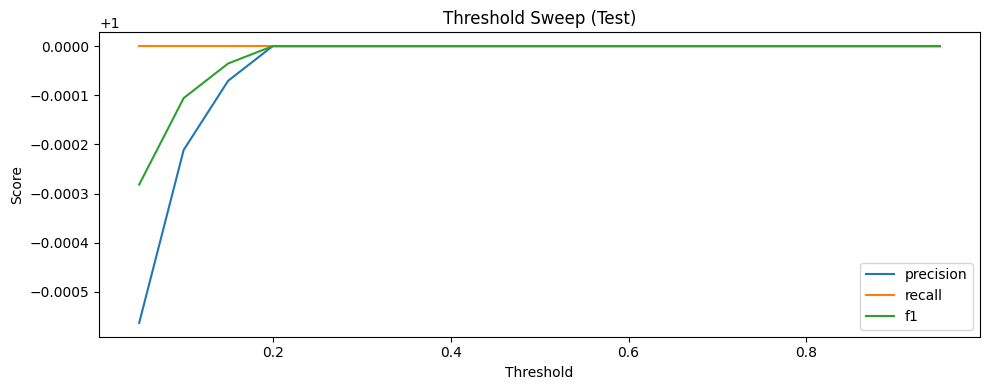

In [9]:
# Threshold sweep (IDS operating point)
thresholds = np.linspace(0.05, 0.95, 19)
rows = []
for t in thresholds:
    m = classification_metrics_from_proba(yte, test_proba, threshold=float(t))
    rows.append({"threshold": float(t), "precision": m["precision"], "recall": m["recall"], "f1": m["f1"]})

sweep_df = pd.DataFrame(rows)
print_section("Threshold Sweep (Test)")
display(sweep_df)

plt.figure(figsize=(10,4))
plt.plot(sweep_df["threshold"], sweep_df["precision"], label="precision")
plt.plot(sweep_df["threshold"], sweep_df["recall"], label="recall")
plt.plot(sweep_df["threshold"], sweep_df["f1"], label="f1")
plt.title("Threshold Sweep (Test)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.tight_layout()
plt.show()


In [10]:
# Save artifacts: model, preprocessor, metrics
ensure_dir(cfg.out_dir)

# Save preprocessor
prep_path = os.path.join(cfg.out_dir, "preprocessor.joblib")
joblib.dump(preprocessor, prep_path)

# Save Keras model (Keras 3 requires extension)
model_path = os.path.join(cfg.out_dir, f"{cfg.model_name}.keras")
clf.save(model_path)

# Export SavedModel for serving / TFLite conversion
savedmodel_dir = os.path.join(cfg.out_dir, f"{cfg.model_name}_savedmodel")
clf.export(savedmodel_dir)

# Save metrics
metrics_payload = {
    "train": train_metrics,
    "val": val_metrics,
    "test": test_metrics,
    "threshold_sweep_test": rows,
}
save_json(os.path.join(cfg.out_dir, "metrics.json"), metrics_payload)

print_section("Saved Artifacts")
print("preprocessor:", prep_path)
print("model (.keras):", model_path)
print("SavedModel dir:", savedmodel_dir)
print("metrics.json:", os.path.join(cfg.out_dir, "metrics.json"))


INFO:tensorflow:Assets written to: ../artifacts_classifier\dos_syn_mlp_savedmodel\assets


INFO:tensorflow:Assets written to: ../artifacts_classifier\dos_syn_mlp_savedmodel\assets


Saved artifact at '../artifacts_classifier\dos_syn_mlp_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 95), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1534283992144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1534283993680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1534283994640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1534283993296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1534283993104: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1534283995600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1534283995792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1534283996368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1534283996752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1534283995984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1534283996560